#Processing Data 
This script is used to take all the available data (images, prediction, mean indices and wheater data) and save them into a csv file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/nc_data/

In [ ]:
# Replace 'local_storage_directory', 'netcdf_dir' and 'csv_dir' by respectively
# the directory path to Copernicus Marine data, the directory path to netcdf files
# and the directory path to csv files
local_storage_directory = '/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/nc_data/'

In [ ]:
%%bash
pip install xarray
pip install -U imagecodecs

In [ ]:
import xarray as xr
import os
import csv
import pandas as pd
import numpy as np
import tifffile

In [ ]:
### Upload images and their prediction
#load images 
pred_png = list()

# Mean lists
mean_ndvi_forest = list()
mean_ndvi_no_forest = list()

mean_msavi_forest = list()
mean_msavi_no_forest = list()

forest_perc = list()
no_forest_perc = list()

# Indices dictionary
mean_ndvi = dict()
mean_msavi = dict()
percentage = dict()
mean_ndvi = {0:mean_ndvi_no_forest,1:mean_ndvi_forest}
mean_msavi = {0:mean_msavi_no_forest,1:mean_msavi_forest}
percentage = {0:no_forest_perc,1:forest_perc}


test_path = "/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/datadrive/forest/processed"
true = 'Test/masks'
pred = 'predictions_numpy/fpn_vi_final'
img = 'Test/images'


raw_data = {}
names_images = sorted(os.listdir(os.path.join(test_path,true)))


raw_data['image_name'] = names_images


#for image in names_images[0:1]:
for image in names_images:
    path_mask = os.path.join(test_path,true,image)
    mask_open = tifffile.imread(path_mask)

    path_pred = os.path.join(test_path,pred,image)
    pred_open = np.load(path_pred+'.npy')

    path_image = os.path.join(test_path,img,image)
    img_open = tifffile.imread(path_image)

    # Calcolo ndvi e msavi
    red = img_open[...,2]
    nir = img_open[...,3]
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
    msavi = nir.astype(float) + 0.5 - (0.5 * np.sqrt((2 * nir.astype(float) + 1)**2 - 8 * (nir.astype(float) - (2 * red.astype(float)))))

    img_open = np.dstack((img_open, ndvi.astype(np.float32, order='C'), msavi.astype(np.float32, order='C')))
    
    for glac_class in range(0,2):
      if glac_class == 1:
        mean_ndvi_forest.append(round(img_open[pred_open==glac_class][:,4].mean().item(),6))
        mean_msavi_forest.append(round(img_open[pred_open==glac_class][:,5].mean().item(),6))
        forest_perc.append(round((pred_open == glac_class).sum()/(512*512),6))
        mean_ndvi[glac_class] = mean_ndvi_forest
        mean_msavi[glac_class] = mean_msavi_forest
        percentage[glac_class] = forest_perc
      else:
        mean_ndvi_no_forest.append(round(img_open[pred_open==glac_class][:,4].mean().item(),6))
        mean_msavi_no_forest.append(round(img_open[pred_open==glac_class][:,5].mean().item(),6))
        no_forest_perc.append(round((pred_open == glac_class).sum()/(512*512),6))
        mean_ndvi[glac_class] = mean_ndvi_no_forest
        mean_msavi[glac_class] = mean_msavi_no_forest
        percentage[glac_class] = no_forest_perc
      

# Final dictionary
mean_values = dict()
mean_values['ndvi'] = mean_ndvi
mean_values['msavi'] = mean_msavi
mean_values['percentage'] = percentage 


raw_data["NoForestPercentage"] = mean_values['percentage'][0]
raw_data["ForestPercentage"] = mean_values['percentage'][1]
raw_data["MeanNoForestNDVI"] = mean_values['ndvi'][0]
raw_data["MeanForestNDVI"] = mean_values['ndvi'][1]
raw_data["MeanNoForestMSAVI"] = mean_values['msavi'][0]
raw_data["MeanForestMSAVI"] = mean_values['msavi'][1]


sat_list = list()
for el in raw_data['image_name']:
  if 'S2A' in el:
    sat_list.append('Sentinel-2A')
  elif 'S2B' in el:
    sat_list.append('Sentinel-2B')
  else:
    sat_list.append('Unknown')
raw_data["Satellite"] = sat_list


# Check the original tile of each image
tile = list()
tile_dict = dict()
for el in raw_data['image_name']:
  tile_dict[el] = el[:-10]
tile = list(tile_dict.values())
raw_data['Tile'] = tile


# Processing WRS Paths and Rows for each image
t_list = list()
orbit_list = list()
for el in raw_data['Tile']:
  split = el.split('_')
  t_list.append(split[5][1:])
  orbit_list.append(split[4][1:])
raw_data['TileNumberField'] = t_list
raw_data['OrbitNumber'] = orbit_list


# Processing acquisition date of each image
date_list = list()

for el in raw_data['Tile']:
  datetime = el.split('_')[2]
  yyyy = datetime[:4]
  mm = datetime[4:6]
  dd = datetime[6:8]
  hh = datetime[9:11]
  min = datetime[11:13]
  ss = datetime[13:]
  date_list.append(yyyy+'-'+mm+'-'+dd+' '+hh+':'+min+':'+ss)
raw_data['DateTime'] = date_list


# Converting WRS Path and Row into Latitude and Longitude coordinates and chek for the country
lat_list = list()
long_list = list()
country_list = list()


for path, row in zip(raw_data['TileNumberField'],raw_data['OrbitNumber']):
  if row == '053':
    if path == '20NQG':
      country_list.append('Caracaraí, State of Roraima, Brazil')
      lat_list.append(1.807669)
      long_list.append(-60.216003)
    elif path == '20LMP':
      country_list.append('Ariquemes, State of Rondônia, Brazil')
      lat_list.append(-9.950853)
      long_list.append(-62.91095)
  elif row == '010':
    if path == '20LQN':
      country_list.append('Aripuanã, State of Mato Grosso, Brazil')
      lat_list.append(-10.842445)
      long_list.append(-60.167084)
  else:
    country_list.append('Unknown')
    lat_list.append('Unknown')
    long_list.append('Unknown')
raw_data['Latitude'] = lat_list
raw_data['Longitude'] = long_list
raw_data['Location'] = country_list


### Take contstual information about precipitation in each tile
var_name = 'tp'
df1 = pd.DataFrame()
rain_directory = local_storage_directory+'AMAZON_Precipitation/'
for filename in os.listdir(rain_directory):
    
    ds = xr.open_dataset(rain_directory + filename)
    df = ds.to_dataframe()
    df['tile_name'] = filename[:-3]
    
    # Compute the total precipitation over the whole day
    tot_prec = df[var_name].sum()*1000

    df.drop('tp', inplace=True, axis=1)
    df['TotPrecipitation']=tot_prec
    df2 = df[0:1]
    df1 = pd.concat([df1,df2])

df1 = df1.set_index('tile_name')
tot_prec = list()
i = 0
for x in raw_data['Tile']:
  for y in df1.index:
    if x == y:
      tot_prec.append(df1.loc[x]['TotPrecipitation'])
    else:
      pass
raw_data['TotPrecipitation'] = tot_prec


### Take contstual information about temperature in each tile
var_name = 't2m'
df1 = pd.DataFrame()
temp_directory = local_storage_directory+'AMAZON_Temperature/'
for filename in os.listdir(temp_directory):
    
    ds = xr.open_dataset(temp_directory + filename)
    df = ds.to_dataframe()
    df['tile_name'] = filename[:-3]
    
    # Conversion from Kelvin to Celsius
    if var_name:
        df[var_name] = df[var_name].apply(lambda x: x - 273,15)
    
    # Compute the mean temperature, the max temperature and the min temperature over the whole day
    max = df[var_name].max()
    min = df[var_name].min()
    mean = df[var_name].mean()

    df.drop('t2m', inplace=True, axis=1)
    df['AvgTemp']=round(mean,3)
    df['MaxTemp']=round(max,3)
    df['MinTemp']=round(min,3)
    df2 = df[0:1]
    df1 = pd.concat([df1,df2])

df1 = df1.set_index('tile_name')
mean_t = list()
max_t = list()
min_t = list()
i = 0
for x in raw_data['Tile']:
  for y in df1.index:
    if x == y:
      mean_t.append(df1.loc[x]['AvgTemp'])
      max_t.append(df1.loc[x]['MaxTemp'])
      min_t.append(df1.loc[x]['MinTemp'])
    else:
      pass
raw_data['AvgTemp'] = mean_t
raw_data['MaxTemp'] = max_t
raw_data['MinTemp'] = min_t


# Creates pandas dataframe
df = pd.DataFrame(raw_data, columns = ['image_name','Tile','TileNumberField','OrbitNumber', 'DateTime', 'Satellite', 
                                       'AvgTemp', 'MaxTemp', 'MinTemp','TotPrecipitation',
                                       'Location','Latitude','Longitude',
                                       'NoForestPercentage','ForestPercentage','MeanNoForestNDVI','MeanForestNDVI','MeanNoForestMSAVI','MeanForestMSAVI'])

In [ ]:
df

,image_name,Tile,TileNumberField,OrbitNumber,DateTime,Satellite,AvgTemp,MaxTemp,MinTemp,TotPrecipitation,Location,Latitude,Longitude,NoForestPercentage,ForestPercentage,MeanNoForestNDVI,MeanForestNDVI,MeanNoForestMSAVI,MeanForestMSAVI
0,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,20NQG,053,2020-01-11 14:27:01,Sentinel-2A,26.863,32.600,23.671,0.069295,"Caracaraí, State of Roraima, Brazil",1.807669,-60.216003,0.187809,0.812191,0.506364,0.854418,0.279276,0.842130
1,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,20NQG,053,2020-01-11 14:27:01,Sentinel-2A,26.863,32.600,23.671,0.069295,"Caracaraí, State of Roraima, Brazil",1.807669,-60.216003,0.337780,0.662220,0.503824,0.835773,0.282696,0.819925
2,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,20NQG,053,2020-01-11 14:27:01,Sentinel-2A,26.863,32.600,23.671,0.069295,"Caracaraí, State of Roraima, Brazil",1.807669,-60.216003,0.497417,0.502583,0.657487,0.842381,0.576476,0.828367
3,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_2...,20NQG,053,2020-01-11 14:27:01,Sentinel-2A,26.863,32.600,23.671,0.069295,"Caracaraí, State of Roraima, Brazil",1.807669,-60.216003,0.622242,0.377758,0.176467,0.227962,-0.402728,-0.259696
4,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.149055,0.850945,0.544945,0.888191,0.356890,0.881115
5,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.803551,0.196449,0.758945,0.870634,0.715019,0.861026
6,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.089718,0.910282,0.540952,0.910409,0.333071,0.905969
7,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.419422,0.580578,0.780910,0.908119,0.741238,0.903460
8,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.468048,0.531952,0.743282,0.858516,0.699349,0.847488
9,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_2...,20LQN,010,2020-02-17 14:16:51,Sentinel-2A,26.955,33.044,22.849,4.254119,"Aripuanã, State of Mato Grosso, Brazil",-10.842445,-60.167084,0.276691,0.723309,0.705845,0.851730,0.648832,0.839576


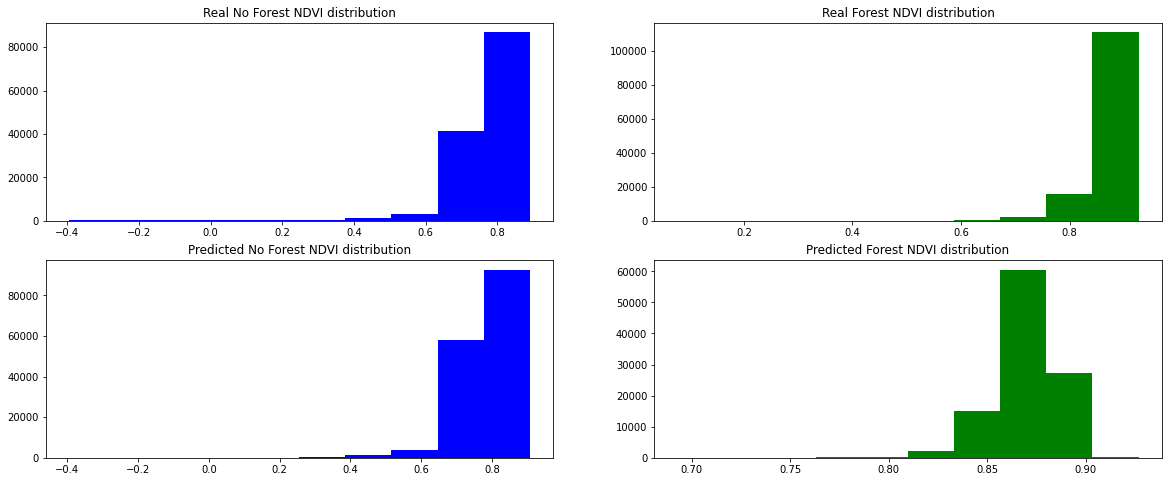

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(20,8))
ax[0,0].hist(img_open[mask_open ==0][:,4], color="blue")
ax[0,0].set_title("Real No Forest NDVI distribution",fontsize=12)
ax[0,1].hist(img_open[mask_open==1][:,4], color="green")
ax[0,1].set_title("Real Forest NDVI distribution",fontsize=12)
ax[1,0].hist(img_open[pred_open==0][:,4], color="blue")
ax[1,0].set_title("Predicted No Forest NDVI distribution",fontsize=12)
ax[1,1].hist(img_open[pred_open==1][:,4], color="green")
ax[1,1].set_title("Predicted Forest NDVI distribution",fontsize=12)
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/prova_csv.csv', index=False)

The next cell has been used to save figure with a legend. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

test_path = "/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/datadrive/forest/processed"
pred = 'predictions_numpy/fpn_vi_final'
legend = test_path + '/predictions_legends/'

pred_png = sorted(os.listdir(os.path.join(test_path,pred)))

if not os.path.exists(legend):
    os.makedirs(legend)

#for image in names_images[0:1]:
for image in pred_png:
    
    path_pred = os.path.join(test_path,pred,image)
    pred_open = np.load(path_pred)
    print(image, pred_open.shape)

    filename = image.split("/")[-1].replace("npy","png")
    plt.imshow(pred_open)

    noforest = mpatches.Patch(color='#440154', label='No Forest')
    forest = mpatches.Patch(color='#fde724', label='Forest')

    plt.legend(handles=[noforest, forest],loc="upper left")
    plt.savefig(f"{legend}{filename}")
    plt.close()

In [ ]:
 !pip install earthpy

(512, 512, 3)
(3, 512, 512)


<Figure size 432x288 with 0 Axes>

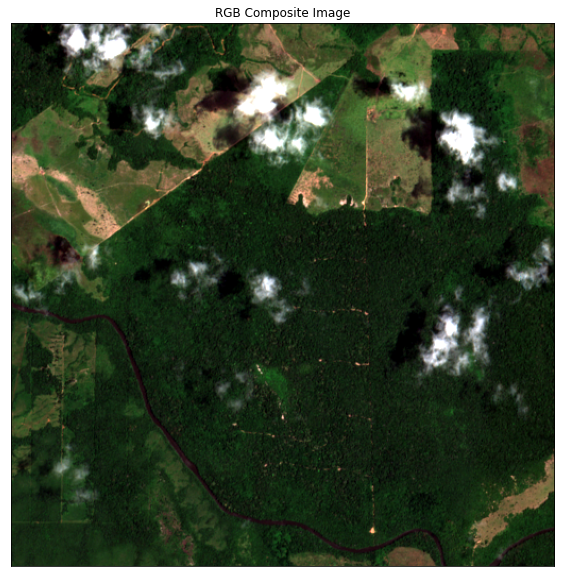

In [ ]:
mask_open = tifffile.imread('/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/datadrive/forest/processed/Test/images/S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_21_09.tif')

# Per vedere immagine RGB del dataset sulle foreste
import earthpy.plot as ep
image = np.dstack((mask_open[...,0],mask_open[...,1],mask_open[...,2]))

image2 = image.transpose(2,0,1)

ep.plot_rgb(image2,
            title="RGB Composite Image",
            stretch=True,
            str_clip=1)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/Tesi/deforestation_mapping-tesi/datadrive/forest/processed/Test/images/S2A_MSIL2A_20200217T141651_N0209_R010_T20LQN_20200217T160045_21_09.png")
plt.close()